In [2]:
# !molecule_generation preprocess INPUT_DIR OUTPUT_DIR TRACE_DIR --generation-order=canonical

In [41]:
import os
os.chdir('/data/ongh0068/l1000/moler_reference')

In [2]:
import gzip
import pickle

with gzip.open('/data/ongh0068/l1000/trace_playground/metadata.pkl.gz', 'rb') as f:
     metadata= pickle.load(f)

2022-12-07 08:29:38.848042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [55]:
import gzip
import pickle

with gzip.open('/data/ongh0068/l1000/trace_playground/train_0/train_0.pkl.gz', 'rb') as f:
     train= pickle.load(f)

# Misc TODOs

1. Add a motif embedding layer to the GNN => need to look into whether there are specific gnn layers for this
2. Dataset => validate if it is correct
3. Implement function for storing Data objects in the Pytorch geometric dataset
4. Implement all the helper function for the pytorch geometric dataset

# Dataset
The original dataset uses a function to randomly decide whether to include or exclude a particular partial graph from the batch. Instead of that, we try to simply save all Data objects a separate .pt files => at training time, we list all the file paths and then sample from the file paths uniformly 

- Downsides => will occupy more memory: potential optimisations (TODOs) would be to save as compressed file and only decompress at training time.
- Upside => less preprocessing time at training time


There will be 1 dataset object for each of the train/validation/test splits

In [4]:
count = 0
for step in train[0]:
#     print(step)
    count += 1
    if count == 5:
        break

In [11]:
from torch_geometric.data import Dataset
import os
from molecule_generation.chem.motif_utils import get_motif_type_to_node_type_index_map


def get_motif_type_to_node_type_index_map(
    motif_vocabulary, num_atom_types
):
    """Helper to construct a mapping from motif type to shifted node type."""

    return {
        motif: num_atom_types + motif_type
        for motif, motif_type in motif_vocabulary.vocabulary.items()
    }



class MolerDataset(Dataset):
    def __init__(
        self, 
        root, 
        raw_moler_trace_dataset_parent_folder, # absolute path 
        output_pyg_trace_dataset_parent_folder, # absolute path
        split = 'train',
        transform=None, 
        pre_transform=None, 
    ):
        super().__init__(root, transform, pre_transform)
        self._transform = transform 
        self._pre_transform = pre_transform
        self._raw_moler_trace_dataset_parent_folder = raw_moler_trace_dataset_parent_folder
        self._output_pyg_trace_dataset_parent_folder = output_pyg_trace_dataset_parent_folder
        self._split = split
        

    @property
    def raw_file_names(self):
        """
        Raw generation trace files output from the preprocess function of the cli. These are zipped pickle
        files. This is the actual file name without the parent folder.
        """
        raw_file_paths_folder = os.path.join(self._raw_moler_trace_dataset_parent_folder, self._split)
        assert os.path.exist(raw_file_paths_folder), f'{raw_file_paths_folder} does not exist.'
        raw_generation_trace_files = [file_path for file_path in os.listdir(raw_file_paths_folder)]
        return raw_generation_trace_files

    @property
    def processed_file_names(self):
        """Processed generation trace objects that are stored as .pt files"""
        processed_file_paths_folder = os.path.join(self._output_pyg_trace_dataset_parent_folder, self._split)
        assert os.path.exist(raw_file_paths_folder), f'{raw_file_paths_folder} does not exist.'
        processed_generation_trace_files = [os.path.join(file)  for file in os.listdir(processed_file_paths_folder)]
        return processed_generation_trace_files
    
    @property
    def processed_file_names_size(self):
        return len(self.processed_file_names)
    
    @property 
    def metadata(self):
        return self._metadata

    def node_types_to_multi_hot(self, node_types):
        """Convert between string representation to multi hot encoding of correct node types.

        Note: implemented here for backwards compatibility only.
        """
        return np.zeros(shape=(self.num_node_types,), dtype=np.float32)

    def node_type_to_index(self, node_type):
        motif_node_type_index = self._motif_to_node_type_index.get(node_type)

        if motif_node_type_index is not None:
            return motif_node_type_index
        else:
            return self._atom_type_featuriser.type_name_to_index(node_type)
    
    @property
    def num_node_types(self):
        return len(self.node_type_index_to_string)
    
    
    
    def load_metadata(self, metadata_path):
        metadata_file_path = os.path.join(self._raw_moler_trace_dataset_parent_folder, 'metadata.pkl.gz')
        
        with gzip.open(metadata_file_path, 'rb') as f:
             self._metadata = pickle.load(f)
        
        self._atom_type_featuriser = next(
            featuriser
            for featuriser in self._metadata["feature_extractors"]
            if featuriser.name == "AtomType"
        )
        
        self._node_type_index_to_string = self._atom_type_featuriser.index_to_atom_type_map.copy()
        self._motif_vocabulary = self.metadata.get("motif_vocabulary")

        if self._motif_vocabulary is not None:
            self._motif_to_node_type_index = get_motif_type_to_node_type_index_map(
                motif_vocabulary=self._motif_vocabulary,
                num_atom_types=len(self._node_type_index_to_string),
            )

            for motif, node_type in self._motif_to_node_type_index.items():
                self._node_type_index_to_string[node_type] = motif
        else:
            self._motif_to_node_type_index = {}
        

    def process(self):
        """Convert raw generation traces into individual .pt files for each of the trace steps."""
        # only call process if it was not called before
        if self.processed_file_names_size > 0:
            pass
        else:
            for pkl_file_path in self.raw_file_names:
                generation_steps = self._convert_data_shard_to_list_of_trace_steps(pkl_file_path)
                for molecule_idx, molecule_gen_steps in generation_steps:
                    for step_idx, step in enumerate(molecule_gen_steps):
                        file_name = f'{pkl_file_path}_mol_{molecule_idx}_step_{step_idx}.pt'
                        file_path = os.path.join(self._output_pyg_trace_dataset_parent_folder, file_name)
                        torch.save(step, file_path)

    def _convert_data_shard_to_list_of_trace_steps(self, pkl_file_path):
        # TODO: multiprocessing to speed this up
        generation_steps = []
        
        with gzip.open(pkl_file_path, 'rb') as f:
            molecules = pickle.load(f)
            for molecule_idx, molecule in enumerate(molecules): 
                generation_steps.extend([i, self._extract_generation_steps(molecule)])
                
        return generation_steps
            
    def _extract_generation_steps(self, molecule):
        for gen_step in molecule:
            x = gen_step.partial_node_features
            node_categorical_features = gen_step.node_categorical_features
        
    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [6]:
import torch
import numpy as np

In [197]:
with gzip.open('/data/ongh0068/l1000/trace_playground/metadata.pkl.gz', 'rb') as f:
     metadata= pickle.load(f)

atom_type_featuriser = next(
    featuriser
    for featuriser in metadata["feature_extractors"]
    if featuriser.name == "AtomType"
)

node_type_index_to_string = atom_type_featuriser.index_to_atom_type_map.copy()
motif_vocabulary = metadata.get("motif_vocabulary")

if motif_vocabulary is not None:
    motif_to_node_type_index = get_motif_type_to_node_type_index_map(
        motif_vocabulary=motif_vocabulary,
        num_atom_types=len(node_type_index_to_string),
    )

    for motif, node_type in motif_to_node_type_index.items():
        node_type_index_to_string[node_type] = motif

In [223]:
def num_node_types():
    return len(node_type_index_to_string)

def node_type_to_index(node_type):
    return atom_type_featuriser.type_name_to_index(node_type)

def node_types_to_indices(node_types):
    node_type_to_index
    """Convert list of string representations into list of integer indices."""
    return [node_type_to_index(node_type) for node_type in node_types]

def node_types_to_multi_hot(node_types):
    """Convert between string representation to multi hot encoding of correct node types.

    Note: implemented here for backwards compatibility only.
    """
    num_node_types
    correct_indices = node_types_to_indices(node_types)
    multihot = np.zeros(shape=(num_node_types(),), dtype=np.float32)
    for idx in correct_indices:
        multihot[idx] = 1.0
    return multihot



    
train_sample = train[0]


graph_property_values = dict(train_sample.graph_property_values)

molecule_gen_steps = []
for gen_step in train_sample:
    gen_step_features = {}
    gen_step_features['x'] = gen_step.partial_node_features
    gen_step_features['focus_node'] = gen_step.focus_node
    
    # have an edge type attribute to tell apart each of the 3 bond types
    edge_indexes = []
    edge_types= []
    for i, adj_list in enumerate(gen_step.partial_adjacency_lists):
        if len(adj_list) != 0:
            edge_index = torch.tensor(adj_list).T
            edge_indexes += [edge_index]
            edge_types += [i]*len(adj_list)
    gen_step_features['edge_index'] = torch.cat(edge_indexes, 1)
    gen_step_features['edge_type'] = torch.tensor(edge_types)
    gen_step_features['correct_edge_choices'] = gen_step.correct_edge_choices
    
    # TODO for correct edge choices, since some steps have, some steps don't
    # we need to subclass the dataloader's collate function and add a 
    # attribute similar to ptr to get the idx of the graphs that require this
    
    # For all other attributes that have always have the same dimensions
    # but might be empty, we can use -1 as a placeholder
    
    
    num_correct_edge_choices = np.sum(gen_step.correct_edge_choices)
    gen_step_features['num_correct_edge_choices'] = num_correct_edge_choices
    gen_step_features['stop_node_label'] = int(num_correct_edge_choices == 0)
    gen_step_features['valid_edge_choices'] = gen_step.valid_edge_choices
    gen_step_features["correct_edge_types"] = gen_step.correct_edge_types
    gen_step_features["partial_node_categorical_features"] = gen_step.partial_node_categorical_features
    if gen_step.correct_attachment_point_choice is not None:
        gen_step_features["correct_attachment_point_choice"] = list(gen_step.valid_attachment_point_choices).index(gen_step.correct_attachment_point_choice)
    else:
        gen_step_features["correct_attachment_point_choice"] = []
    gen_step_features["valid_attachment_point_choices"] = gen_step.valid_attachment_point_choices
    
    # And finally, the correct node type choices. Here, we have an empty list of
    # correct choices for all steps where we didn't choose a node, so we skip that:
    if gen_step.correct_node_type_choices is not None:
        gen_step_features["correct_node_type_choices"] = node_types_to_multi_hot(gen_step.correct_node_type_choices)
    else:
        gen_step_features["correct_node_type_choices"] = []
    gen_step_features['correct_first_node_type_choices'] = node_types_to_multi_hot(train_sample.correct_first_node_type_choices)
    
    # Add graph_property_values
    gen_step_features = {**gen_step_features, **graph_property_values}
    
    molecule_gen_steps += [gen_step_features]
for i in range(len(molecule_gen_steps)):
    for k,v in molecule_gen_steps[i].items():
        molecule_gen_steps[i][k] = torch.tensor(molecule_gen_steps[i][k])
    

/tmp/ipykernel_997897/2386230476.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  molecule_gen_steps[i][k] = torch.tensor(molecule_gen_steps[i][k])


In [224]:
import torch
from torch_geometric.data import Data


# class MolerTraceData(Data):
#     def __cat_dim__(self, key, value, *args, **kwargs):
#         if key == 'foo':
#             return None
#     else:
#         return super().__cat_dim__(key, value, *args, **kwargs)


pyg_data = []
for step in molecule_gen_steps:
    pyg_data.append(Data(**step))
    

In [225]:
from torch_geometric.loader import DataLoader
loader = DataLoader(pyg_data, batch_size=16, shuffle=False, follow_batch = [
    'correct_edge_choices',
    'correct_edge_types',
    'valid_edge_choices',
    'valid_attachment_point_choices',
    'correct_attachment_point_choice',
    'correct_node_type_choices'
])

In [226]:
batch.correct_edge_choices_ptr, batch.correct_node_type_choices_ptr

(tensor([ 0,  0,  2,  3,  5,  6,  9, 11, 15, 18, 23, 27, 33, 38, 42, 48, 53]),
 tensor([   0,  139,  139,  278,  278,  417,  417,  556,  556,  695,  695,  834,
          834,  834,  973,  973, 1112]))

In [216]:
batch.correct_edge_choices_batch

tensor([ 1,  1,  2,  3,  3,  4,  5,  5,  5,  6,  6,  7,  7,  7,  7,  8,  8,  8,
         9,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12,
        12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15])

In [215]:
batch.correct_edge_choices.shape, batch.correct_node_type_choices.shape

(torch.Size([53]), torch.Size([1112]))

In [227]:
def pprint_pyg_obj(batch):
    for key in vars(batch)['_store'].keys():
        if key.startswith('_'):
            continue
        print(f'{key}: {batch[key].shape}')
for batch in loader:
    pprint_pyg_obj(batch)
    break

x: torch.Size([126, 32])
edge_index: torch.Size([2, 212])
focus_node: torch.Size([16])
edge_type: torch.Size([212])
correct_edge_choices: torch.Size([53])
correct_edge_choices_batch: torch.Size([53])
correct_edge_choices_ptr: torch.Size([17])
num_correct_edge_choices: torch.Size([16])
stop_node_label: torch.Size([16])
valid_edge_choices: torch.Size([53, 2])
valid_edge_choices_batch: torch.Size([53])
valid_edge_choices_ptr: torch.Size([17])
correct_edge_types: torch.Size([9, 3])
correct_edge_types_batch: torch.Size([9])
correct_edge_types_ptr: torch.Size([17])
partial_node_categorical_features: torch.Size([126])
correct_attachment_point_choice: torch.Size([0])
correct_attachment_point_choice_batch: torch.Size([0])
correct_attachment_point_choice_ptr: torch.Size([17])
valid_attachment_point_choices: torch.Size([0])
valid_attachment_point_choices_batch: torch.Size([0])
valid_attachment_point_choices_ptr: torch.Size([17])
correct_node_type_choices: torch.Size([1112])
correct_node_type_choi

In [238]:
from torch_geometric.nn import RGATConv

conv1 = RGATConv(in_channels = batch.x.shape[1], out_channels = batch.x.shape[1]//2, num_relations = 3)

In [239]:
conv1(batch.x, batch.edge_index.long(), batch.edge_type).shape # shape: [num_nodes, latent_feature_size]

torch.Size([126, 16])

In [211]:
batch.correct_node_type_choices, batch.correct_node_type_choices_batch

(tensor([0., 1., 0.,  ..., 0., 0., 0.]),
 tensor([ 0,  0,  0,  ..., 15, 15, 15]))

In [176]:
batch.correct_edge_types

tensor([[1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0]], dtype=torch.int32)

In [162]:
pyg_data[11].correct_edge_types

tensor([[0, 1, 0],
        [1, 0, 0]], dtype=torch.int32)

In [121]:
batch.ptr

tensor([  0,   4,   9,  14,  20,  26,  33,  40,  48,  56,  65,  74,  84,  94,
        104, 115, 126])

In [173]:
batch.correct_edge_types_batch

tensor([ 1,  3,  5,  7,  9, 11, 11, 12, 14])

In [128]:
np.repeat(np.arange(5, dtype=np.int32), 2).reshape(-1, 2)

array([[0, 0],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 4]], dtype=int32)

# Issues to resolve

Here, for a batch size of 16, there are 4 nodes in the first sample in the batch and 126 nodes in total as seen from x. the `ptr` attribute tells us where each new graph starts in the batch.


Add the `is_conjugated` and the other bond properties to the preprocessing script as used in ogb https://github.com/snap-stanford/ogb/blob/master/ogb/utils/features.py


(DONE) Add graph property values


Add self loops


(DONE) There is something wrong with the multihot encoding: none of the node types are of value 1

(DONE: `follow_batch` was used instead of the things below)
1. edge_index: how do we tell which belongs to which graph? Does it matter?
2. focus node: NI
3. edge type: same as edge index, how to tell?
4. correct_edge_choices: need to put a -1 for those samples without any?
5. num_correct_edge_choices: NI, for each of the 16 samples => can be used to infer which graphs to use for training the decoder mlps
6. stop_node_label: NI
7. valid_edge_choices: need to put -1 for samples without any
8. correct_edge_types: need to put -1 for samples without any 
9. partial_node_categorical_features: NI
10. correct_attachment_point_choice: need to put -1 for samples without any
11. valid_attachment_point_choices: need to put -1 for samples without any

In [132]:
batch.correct_node_type_choices.unique()


tensor([0.])

In [130]:
batch.ptr[batch.ptr > 50] # use this kind of numpy like indexing to get 
# the values we want



tensor([ 56,  65,  74,  84,  94, 104, 115, 126])

In [52]:
metadata['motif_vocabulary']

{'C1=CC=CC=C1': 0,
 'C1CCNCC1': 1,
 'C1=CC=NC=C1': 2,
 'NC=O': 3,
 'C1CNCCN1': 4,
 'C1CCNC1': 5,
 'O=[N+][O-]': 6,
 'C1CC1': 7,
 'C1COCCN1': 8,
 'O=CO': 9,
 'N=CO': 10,
 'C1=CNN=C1': 11,
 'FC(F)F': 12,
 'CC=O': 13,
 'C1CCOCC1': 14,
 'C1=CC=C2C=CC=CC2=C1': 15,
 'COC=O': 16,
 'CCO': 17,
 'C=CC': 18,
 'C1=CSC=N1': 19,
 'C1=CSC=C1': 20,
 'C1=CON=C1': 21,
 'C1=CC=C2NC=CC2=C1': 22,
 'OC(F)F': 23,
 'O=CNO': 24,
 'CNC=O': 25,
 'CCNC(=O)OC': 26,
 'CCCO': 27,
 'CCC(N)=O': 28,
 'CCC(=O)O': 29,
 'CC(N)=O': 30,
 'CC(C)C': 31,
 'C1CCOC1': 32,
 'C1CCCCC1': 33,
 'C1=NC=C2CCCCC2=N1': 34,
 'C1=COC=C1': 35,
 'C1=CNC=C1': 36,
 'C1=CN=CN=C1': 37,
 'C1=CN=C2C=CC=CC2=C1': 38,
 'C1=CN2N=CC=C2N=C1': 39,
 'C1=CC=C2OC=CCC2=C1': 40,
 'C1=CC=C2N=CC=CC2=C1': 41,
 'C1=CC2=C(CCC2)S1': 42,
 'O=S=O': 43,
 'O=CNCCO': 44,
 'O=CNCCCCCNC=O': 45,
 'O=CNCCC(=O)O': 46,
 'O=CCCO': 47,
 'O=C(O)CS': 48,
 'N[SH](=O)=O': 49,
 'NNC=O': 50,
 'NCCO': 51,
 'NCCCC(N)=O': 52,
 'NC(N)=O': 53,
 'ClC(Cl)Cl': 54,
 'CSCCC(N)C(=O)O': 55,
 'CO

In [41]:
train_sample.correct_first_node_type_choices

['COC=O']

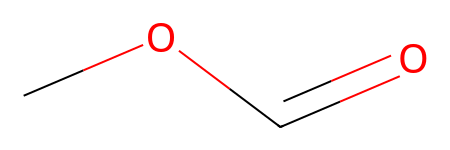

In [44]:
from rdkit import Chem
Chem.MolFromSmiles('COC=O')